# RNN

- The Markov assumption: the current value depends **only** on the immediate previous value (weak)
- An RNN accounts for all previous words

RNNs are more compact (less parameters)

N sequence of length T that has D features : N x T x D : #Sample, #Time, #Feature (argument `batch_first` defines this order). 

- N : Number of samples
- T : sequence length
- D : # inputs
- M : # hidden units (features)
- K : # outputs units
- L : # hidden layers

For forward function the results depends on the initial hidden state in shape (L x N x M) that we can initialize with zero. N is the sample/batch size.

The RNN module returns two outputs

RNN are vulnrable to the vanishing gradient problem to solve this:
- LSTM : Long Short Term Memory
- GRU : Gated Recurrent Unit (simplified version of LSTM)

### GRU

These are all vector of size M (number of hidden units/features)

- z(t) : update gate vector, should I take the new value of h(t) or should I keep the old value h(t-1)
- r(t) : reset gate vector, switch to remember/ forget h(t-1)
- h(t) : hidden state

### LSTM

Like GRU but with more state and gate

- c(t) : cell state (usually ignored)
- h(t) : hidden state
- f(t) : forget gate
- i(t): input/Output gate
- O(t): output gate

Think about all of these as neurans that do binary classification

In [1]:
import torch
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt

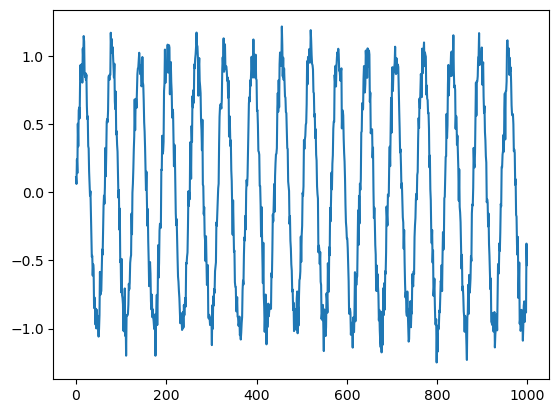

In [2]:
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1
plt.plot(series)
plt.show()

In [3]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden 
        self.K = n_outputs
        self.L = n_rnnlayers
        self.rnn = nn.RNN(
            input_size = self.D,
            hidden_size= self.M,
            num_layers = self.L,
            nonlinearity = 'relu',
            batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        out, _ = self.rnn(X, h0)
        out = self.fc(out[:, -1, :])
        return out
    

In [6]:
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test  = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test  = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [8]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [9]:
def gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, n_epochs = 200 ):
  train_losses = np.zeros(n_epochs)
  test_losses = np.zeros(n_epochs)
  # total number of iteration is in fact #n_epochs * #batches
  for it in range(n_epochs):
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()
      train_losses[it] = loss.item()
      test_outputs = model(X_test)
      test_loss = criterion(test_outputs, y_test)
      test_losses[it] = test_loss.item()
      if (it +1) %5 == 0:
        print(f'Epoch {it+1}/{n_epochs}, Train Loss {loss.item():.4f}, Test Loss {test_loss.item():.4f}')
  return train_losses, test_losses

In [10]:
train_losses, test_losses = gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, n_epochs =200)

Epoch 5/200, Train Loss 0.1041, Test Loss 0.0526
Epoch 10/200, Train Loss 0.0318, Test Loss 0.0627
Epoch 15/200, Train Loss 0.0273, Test Loss 0.0340
Epoch 20/200, Train Loss 0.0332, Test Loss 0.0322
Epoch 25/200, Train Loss 0.0275, Test Loss 0.0288
Epoch 30/200, Train Loss 0.0258, Test Loss 0.0280
Epoch 35/200, Train Loss 0.0250, Test Loss 0.0251
Epoch 40/200, Train Loss 0.0229, Test Loss 0.0251
Epoch 45/200, Train Loss 0.0226, Test Loss 0.0237
Epoch 50/200, Train Loss 0.0218, Test Loss 0.0236
Epoch 55/200, Train Loss 0.0216, Test Loss 0.0230
Epoch 60/200, Train Loss 0.0214, Test Loss 0.0228
Epoch 65/200, Train Loss 0.0211, Test Loss 0.0226
Epoch 70/200, Train Loss 0.0210, Test Loss 0.0224
Epoch 75/200, Train Loss 0.0208, Test Loss 0.0222
Epoch 80/200, Train Loss 0.0206, Test Loss 0.0221
Epoch 85/200, Train Loss 0.0205, Test Loss 0.0220
Epoch 90/200, Train Loss 0.0204, Test Loss 0.0219
Epoch 95/200, Train Loss 0.0203, Test Loss 0.0218
Epoch 100/200, Train Loss 0.0202, Test Loss 0.0217


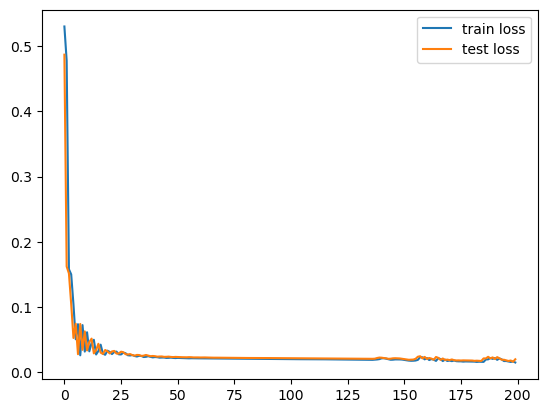

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()
plt.show()

In [12]:
 validation_target = Y[-N//2:]
 validation_prediction  = []

 last_x = X_test[0].view(T)

 while len(validation_prediction)<len(validation_target):
  input_ = last_x.reshape(1,T,1) 
  p = model(input_)
  validation_prediction.append(p[0,0].item())

  last_x = torch.cat((last_x[1:], p[0]))

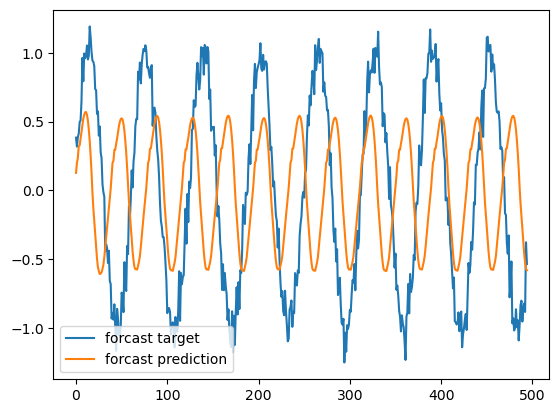

In [13]:
plt.plot(validation_target, label = "forcast target")
plt.plot(validation_prediction, label = "forcast prediction")
plt.legend()